In [52]:
# Import necessary libraries for loading the dataset
import torch
from torchvision import datasets, transforms
from custom_labels import label_mapping, apply_custom_labels

# Load the fashion MNIST dataset with custom labels

In [53]:
data_path = '../data'

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root=data_path, train=True, transform=transform, download=True)
train_dataset.targets = apply_custom_labels(train_dataset.targets)

test_dataset = datasets.FashionMNIST(root=data_path, train=False, transform=transform, download=True)
test_dataset.targets = apply_custom_labels(test_dataset.targets)

# Deep Learning Experimentation and evaluation

In [67]:
# import libraries needed for the DL experiments and evaluation
import torch.nn as nn
from torch.utils.data import random_split
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import os

In [68]:
batch_size = 64

# taking 20% of train as validation
valid_size = int(0.2 * len(train_dataset)) 
train_size = len(train_dataset) - valid_size

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [69]:
def train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, save_dir=None):

    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')

    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculating average training loss for this epoch
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

        # Calculating average validation loss for this epoch
        avg_valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(avg_valid_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}')

        # save model checkpoint
        if save_dir and valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            checkpoint_path = os.path.join(save_dir, f'best_checkpoint.pth')
            print(f"Saving best checkpoint to {checkpoint_path}")
            torch.save(model.state_dict(), checkpoint_path)


    # Plot training and validation curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)

    if save_dir:
        curve_path = os.path.join(save_dir, 'loss_curves.png')
        plt.savefig(curve_path)
    else:
        plt.show()


In [74]:
def evaluate(model, test_loader, num_classes):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    confusion = confusion_matrix(y_true, y_pred)

    class_report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(num_classes)])

    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print('\nConfusion Matrix:')
    print(confusion)
    print('\nClassification Report:')
    print(class_report)


### double CNN model

In [58]:
class DoubleCNN(nn.Module):
    def __init__(self):
        super(DoubleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=len(label_mapping))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Epoch 1/10, Train Loss: 0.1786, Valid Loss: 0.1012
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 2/10, Train Loss: 0.0968, Valid Loss: 0.0904
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 3/10, Train Loss: 0.0777, Valid Loss: 0.0758
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 4/10, Train Loss: 0.0658, Valid Loss: 0.0697
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 5/10, Train Loss: 0.0573, Valid Loss: 0.0659
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 6/10, Train Loss: 0.0501, Valid Loss: 0.0675
Epoch 7/10, Train Loss: 0.0433, Valid Loss: 0.0652
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 8/10, Train Loss: 0.0381, Valid Loss: 0.0705
Epoch 9/10, Train Loss: 0.0346, Valid Loss: 0.0645
Saving best checkpoint to ./outputs/best_checkpoint.pth
Epoch 10/10, Train Loss: 0.0294, Valid Loss: 0.0709


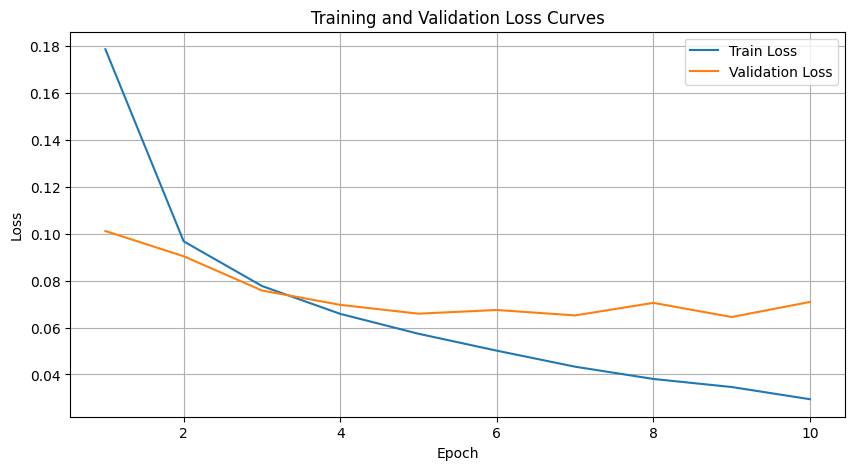

In [59]:

# Initialize the model
double_cnn = DoubleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(double_cnn.parameters(), lr=0.001)

train(double_cnn, train_loader, valid_loader, criterion, optimizer, num_epochs=10,save_dir='./outputs')


The above graph showcases that the model is overfitting, looking at the plot, we can fix the number of epochs to be 3.

In [75]:

# Evaluate the baseline model
evaluate(double_cnn, test_loader, num_classes=5)


Accuracy: 97.73%
F1 Score: 0.9774
Precision: 0.9775
Recall: 0.9773

Confusion Matrix:
[[3904    0   86    2    8]
 [  15  975   10    0    0]
 [  75    4  920    0    1]
 [   1    0    1 2998    0]
 [  16    0    2    6  976]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.97      4000
     Class 1       1.00      0.97      0.99      1000
     Class 2       0.90      0.92      0.91      1000
     Class 3       1.00      1.00      1.00      3000
     Class 4       0.99      0.98      0.98      1000

    accuracy                           0.98     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.98      0.98      0.98     10000

